## utiliser outil tensorboard, matrix de confusion, afficher resultat de json

In [1]:
import os , sys
from os import path
workpath = sys.path[0]
sys.path.append(f'{workpath}\fidle-env\lib\site-packages')
sys.path.append(f'{workpath}\pmd22-23\BDDfactory\lib')
type_models = 'model_128_equilibre'
run_dir = f"{workpath}/resultat_calmip/{type_models}"
#modules basiques
import json
import fidle
import fidle.pwk as pwk 
import numpy as np
from pathlib import Path
import pandas as pd
import skimage as sm
from skimage import io 

#module IA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

## show report

In [2]:
def highlight_max(s):
    is_max = (s == s.max())
    return ['background-color: yellow' if v else '' for v in is_max]

def show_report(file):
    # ---- Read json file
    with open(file) as infile:
        dict_report = json.load( infile )
    output      = dict_report['output']
    description = dict_report['description']
    # ---- about
    pwk.subtitle(f'Report : {Path(file).stem}')
    print(    "Desc.  : ",description,'\n')
    # ---- Create a pandas
    report       = pd.DataFrame (output)
    col_accuracy = [ c for c in output.keys() if c.endswith('Accuracy')]
    col_duration = [ c for c in output.keys() if c.endswith('Duration')]
    # ---- Build formats
    lambda_acc = lambda x : '{:.2f} %'.format(x) if (isinstance(x, float)) else '{:}'.format(x)
    lambda_dur = lambda x : '{:.1f} s'.format(x) if (isinstance(x, float)) else '{:}'.format(x)
    formats = {'Size':'{:.2f} Mo'}
    for c in col_accuracy:   
        formats[c]=lambda_acc
    for c in col_duration:
        formats[c]=lambda_dur
    t=report.style.highlight_max(subset=col_accuracy).format(formats).hide_index()
    display(t)

In [3]:
files = os.listdir(run_dir)
print(files)
for f in files:
    if f[-4:] == 'json':
        print(f)
    if f[:5] == 'model':
        print(f'tag_id is {f[7:]}')
    if f[:3] == 'log':
        print(f'dossier tensorboard: {f}')

['logs_cnn_fVGG_2023-04-23_20h50m05s', 'logs_cnn_fVGG_2023-04-23_20h59m28s', 'models_cnn_fVGG_2023-04-23_20h50m05s', 'models_cnn_fVGG_2023-04-23_20h59m28s', 'report_cnn_fVGG_2023-04-23_20h59m28s.json']
dossier tensorboard: logs_cnn_fVGG_2023-04-23_20h50m05s
dossier tensorboard: logs_cnn_fVGG_2023-04-23_20h59m28s
tag_id is cnn_fVGG_2023-04-23_20h50m05s
tag_id is cnn_fVGG_2023-04-23_20h59m28s
report_cnn_fVGG_2023-04-23_20h59m28s.json


In [4]:
file = 'report_cnn_fVGG_2023-04-23_20h59m28s.json'
show_report(f'{run_dir}/{file}')

<br>**Report : report_cnn_fVGG_2023-04-23_20h59m28s**

Desc.  :  scale=1 batch_size=64 epochs=15 data_aug=[False] 



F:\Temp\ipykernel_2088\2258343395.py:26: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  t=report.style.highlight_max(subset=col_accuracy).format(formats).hide_index()


Dataset,Size,m2_700_112234_sdg_Accuracy,m2_700_112234_sdg_Duration,m2_700_112234_sdg_loss,m2_700_112234_wdg_Accuracy,m2_700_112234_wdg_Duration,m2_700_112234_wdg_loss
img_128,20044.00 Mo,0.98 %,150.5 s,0.063665,-,-,-


## code tensorboard

In [5]:
print(f"tensorboard --logdir {run_dir}\logs_cnn_fVGG_2023-04-23_20h59m28s")

tensorboard --logdir E:\INSA-cour\A4A\Projet_multi\work-dictory/resultat_calmip/model_128_equilibre\logs_cnn_fVGG_2023-04-23_20h59m28s


## preparer les data pour la test 

## les diffs choix de dataset.

In [6]:
datapath = f'{workpath}\datasheet\mmClasses-DataBase-IMG\mmClasses-DataBase-IMG\data_128_equilibre'

## Parameters for CNN and DNN

In [7]:
#pourcentage du dataset à load
scale = 0.2

batch_size    = 64
epochs        = 2
fit_verbosity = 1

index_to_class = ["CUBO","DEC","FCC","FCC-sphere","HCP-sphere","ICO","MnBeta_sphere","OH","RTD","BCC","DODECA"]

## Dataset loading

In [8]:
def read_dataset (filepath : str):
    """entrée : chemin vers le dossier contenant la BDD
    sortie : listes des images et leur classes respectives, mis à l'échelle (scale) et mélangées"""
    
    """
    au lieu d'avoir un set de training 80%, un set de test 20%, j'ai appliqué ici un strategie conseillé si on a beacoup de donnee, 
    un training set 70%, un test set pour validation 15%, et un test final set 15% pour faire l'evaluation. Vu que le test set a une effet parasit sur le training set
    """
    
    L = os.listdir(filepath)   #liste contenenant le nom (en .jpg) de toutes les images
    nb_files = len(L)
    nb_files2load = round(nb_files*scale)
    size = np.shape(io.imread(f'{filepath}/{L[0]}' , as_gray = True))
    
    #initialisation listes sortie
    img = np.zeros ( (nb_files2load , size[0] , size[1]) , dtype = np.float16 )
    ID  = np.zeros ( nb_files2load , dtype = np.int8)
   
    for i in range (nb_files2load):
        
        random_index = np.random.randint(0 , nb_files - i )
        img[i] = io.imread (f'{filepath}/{L[random_index]}',as_gray = True)
        ID [i] = int (L[random_index][:3]) - 1
        L.pop(random_index)    
        
    N = len(img)
    nb_img = N
    a = N*0.7
    b = N*0.85
    img_train = img[0:round(a)]
    img_test  = img[round(a):round(b)]
    img_test_final = img[round(b):]
    ID_train = ID[0:round(a)]
    ID_test  = ID[round(a):round(b)]  
    ID_test_final = ID[round(b):]
    
        
    return img_train,img_test,ID_train,ID_test,nb_img, img_test_final, ID_test_final


In [10]:
img = read_dataset(datapath)

## model evaluate matrix de confusion 

In [11]:
tag_id = 'cnn_fVGG_2023-04-23_20h59m28s'
models = os.listdir(f'{run_dir}\models_{tag_id}')
print(models) # tu choisis un des modeles listés et le mettre dans le variable model_choisit au dessous.

['model_sdg_img_128_e15bs64sc1code2_700_112234.h5']


In [12]:
model_choisit = 'model_sdg_img_128_e15bs64sc1code2_700_112234.h5'
model_choisit = f'{run_dir}\models_{tag_id}\{model_choisit}'
model_evaluated = tf.keras.models.load_model(model_choisit) #load ton model choisite, tu peux aussi copie coller la chemin absolute ou le model est stocké

In [13]:
model_evaluated.summary() # son structure

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 42, 42, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 42, 42, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 42, 42, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 42, 42, 64)        36928     
                                                      

In [14]:
img_test_final = img[0]
ID_test_final = img[2]
score = model_evaluated.evaluate(img_test_final, ID_test_final, verbose=0) #evaluation de ce models

print('Test loss     :', score[0])
print('Test accuracy :', score[1])

Test loss     : 0.04146087169647217
Test accuracy : 0.9871703386306763


## erreurs

88/88 [==============================] - 13s 142ms/step


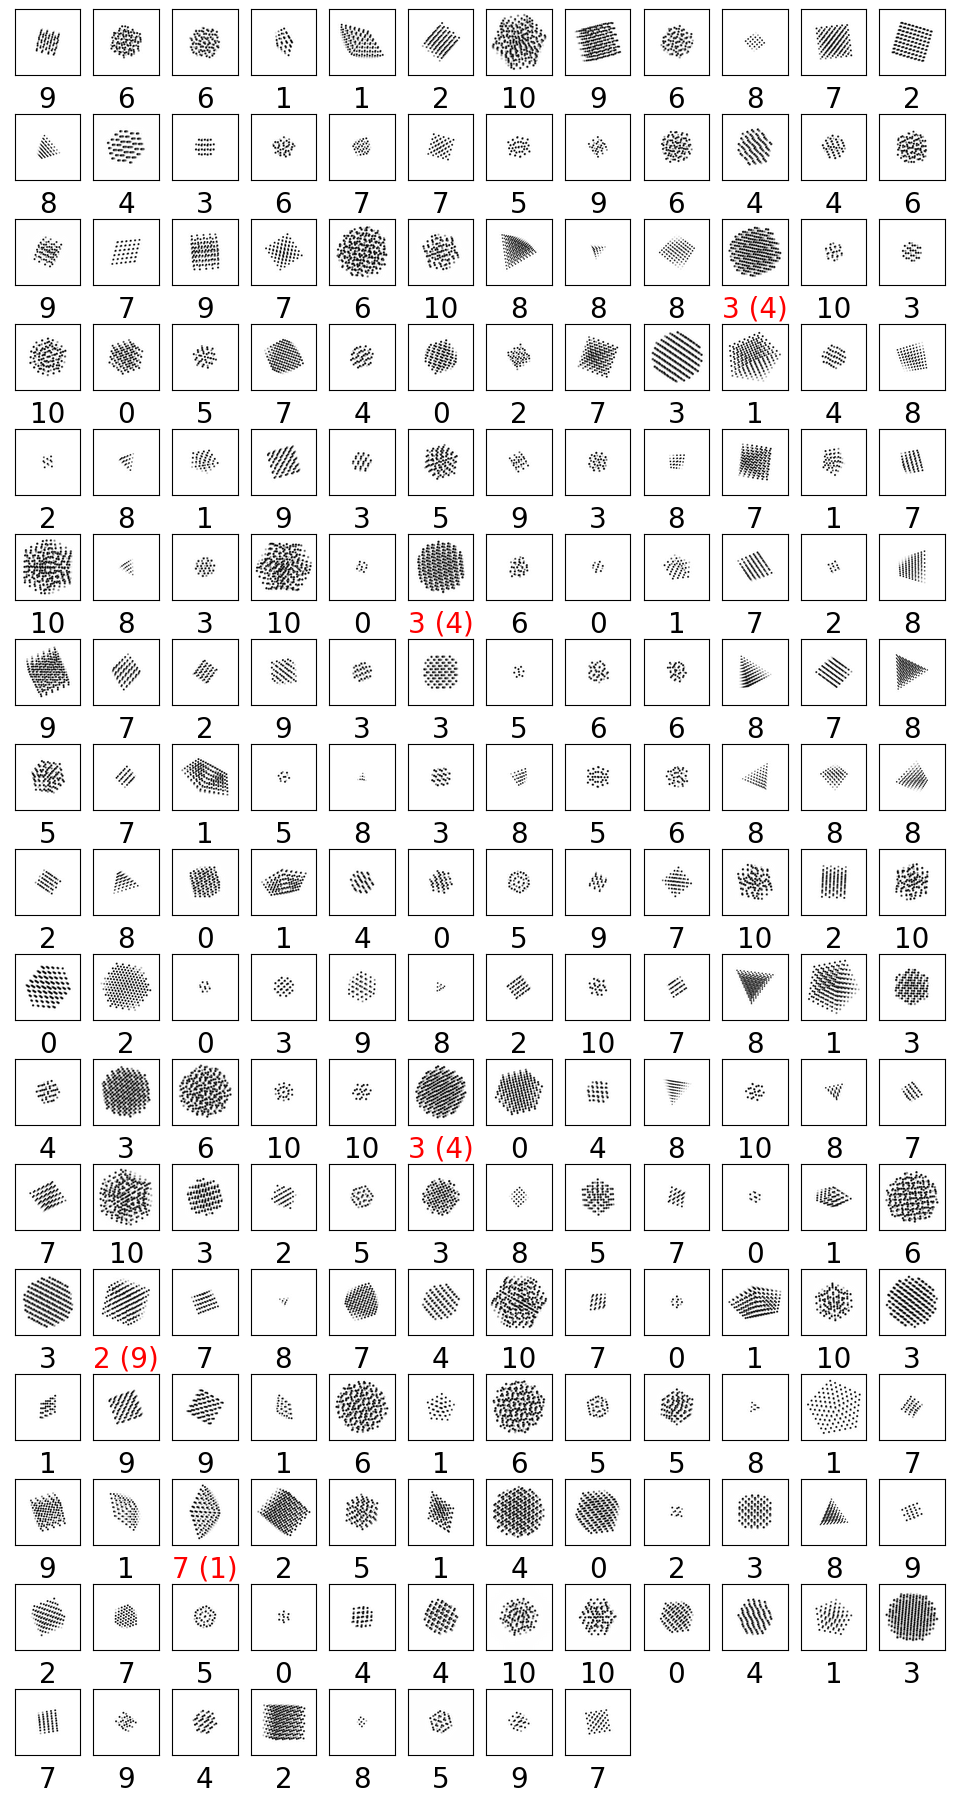

In [15]:
y_sigmoid = model_evaluated.predict(img_test_final)
ID_pred    = np.argmax(y_sigmoid, axis=-1)

pwk.plot_images(img_test_final, ID_test_final, range(0,200), columns=12, x_size=1, y_size=1, y_pred=ID_pred, save_as='04-predictions')

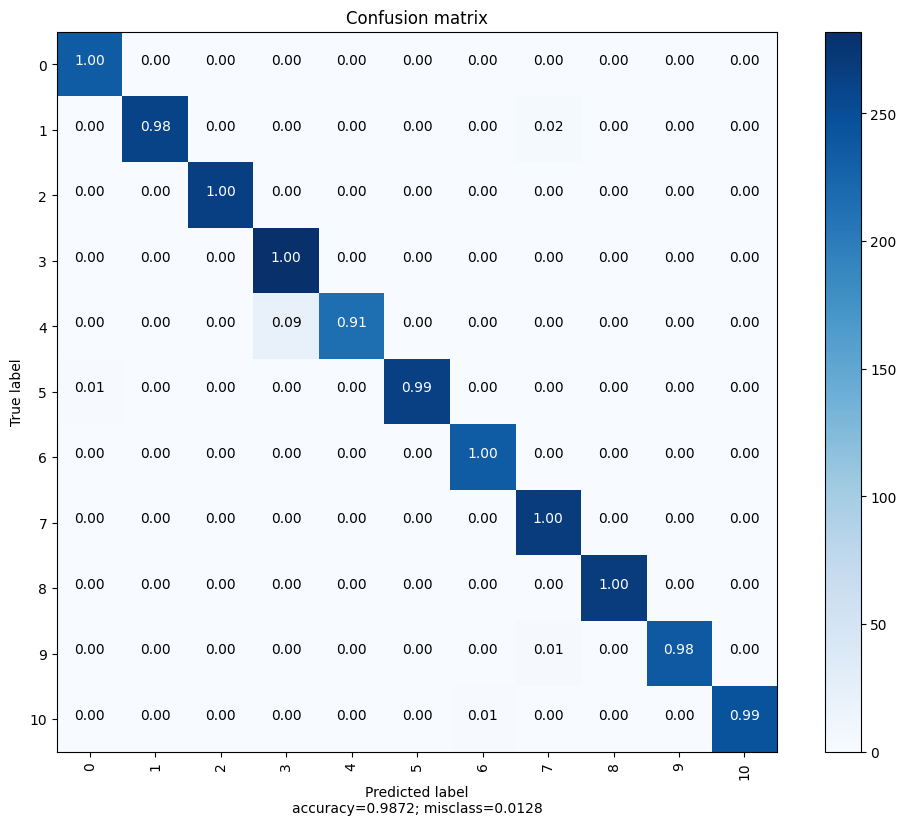

In [16]:
pwk.plot_confusion_matrix(ID_test_final,ID_pred,range(11),normalize=True, save_as='06-confusion-matrix')